In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 340

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

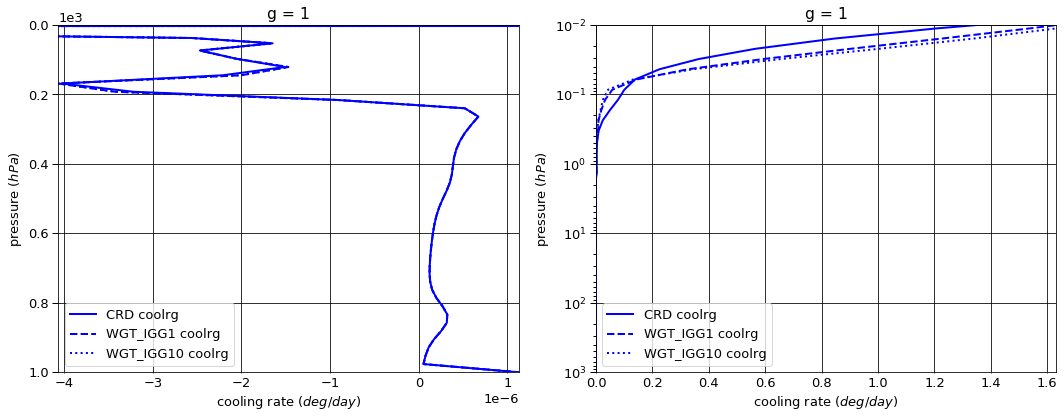

# Figure: cooling rate g-group 2

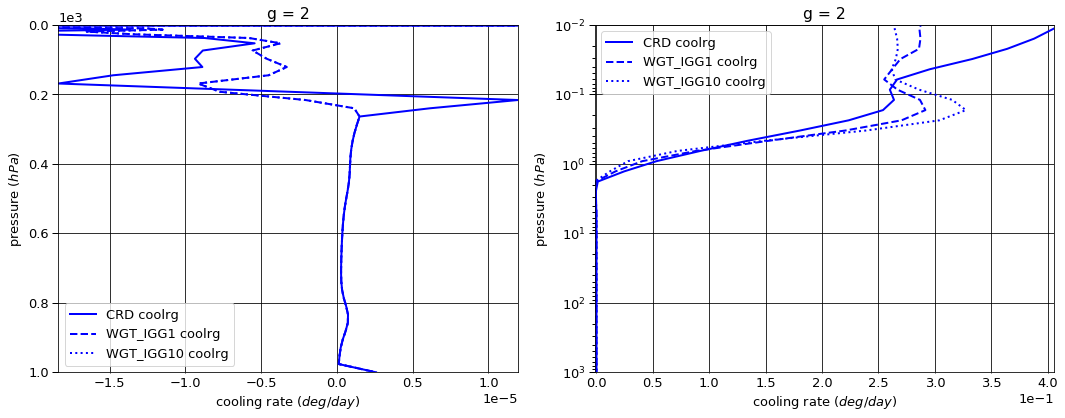

# Figure: cooling rate g-group 3

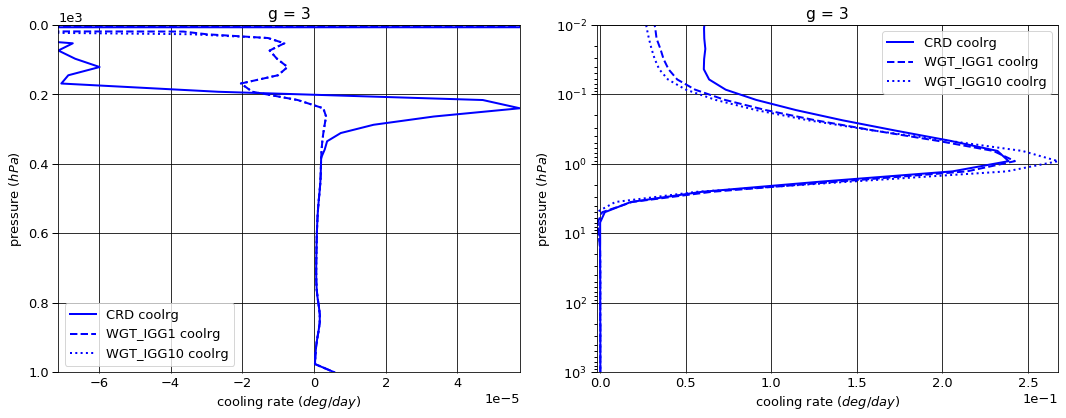

# Figure: cooling rate g-group 4

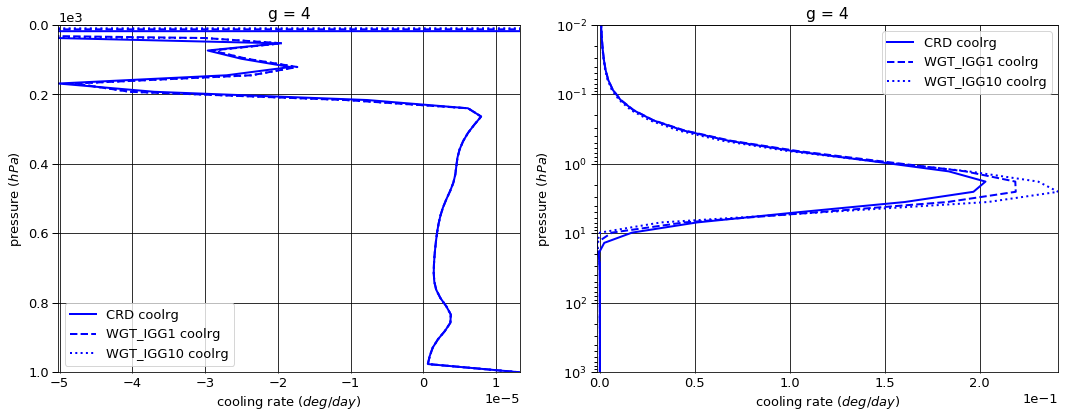

# Figure: cooling rate g-group 5

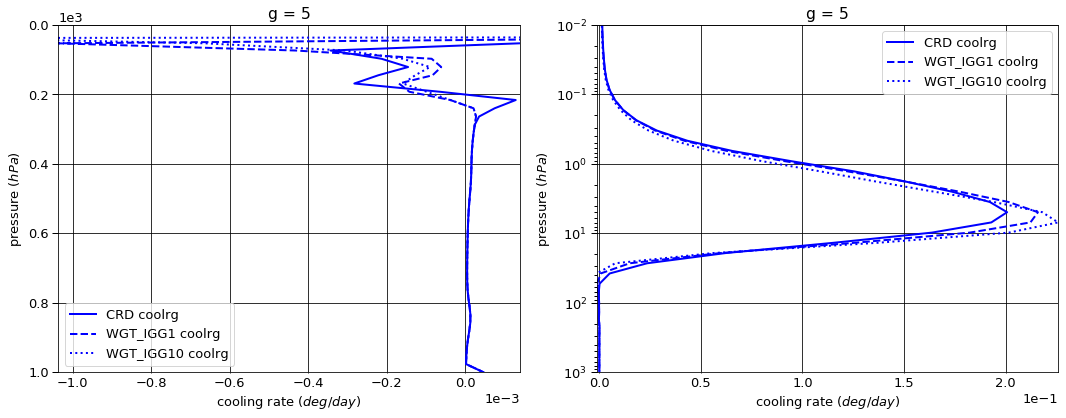

# Figure: cooling rate g-group 6

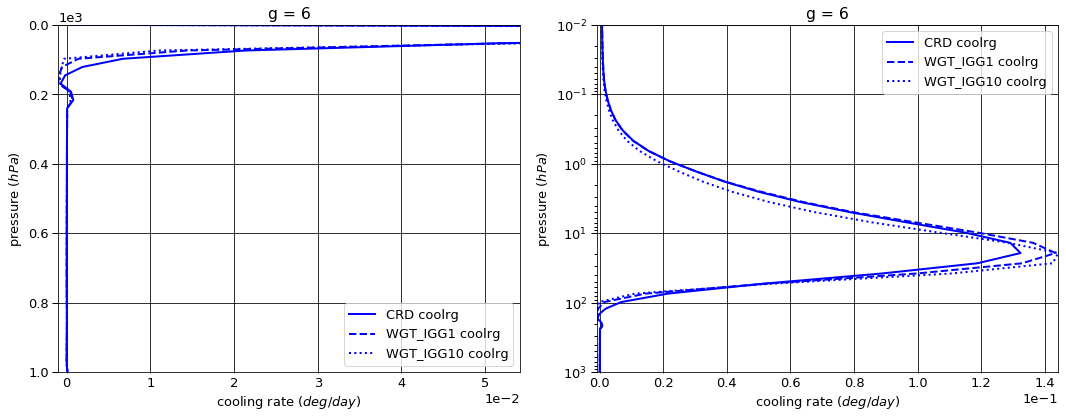

# Figure: cooling rate g-group 7

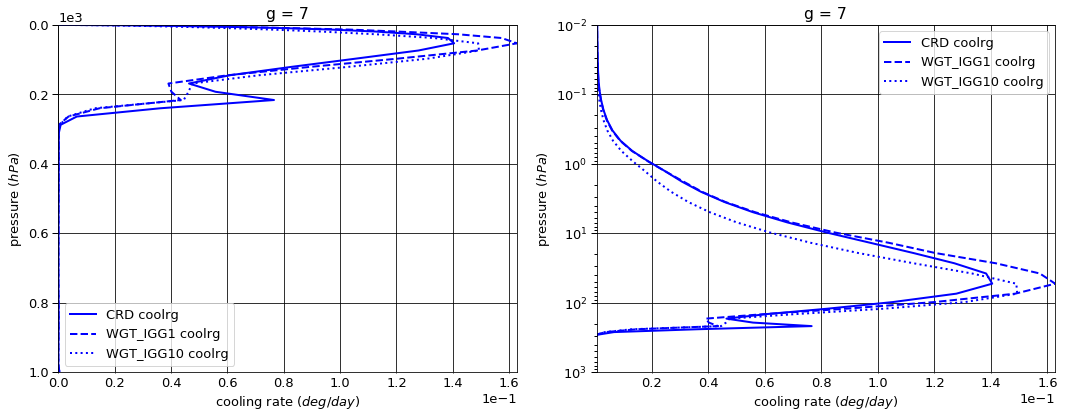

# Figure: cooling rate g-group 8

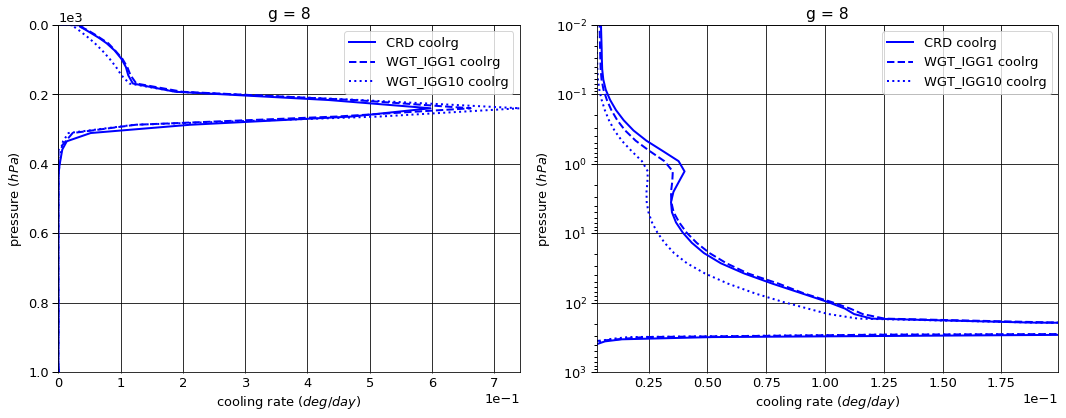

# Figure: cooling rate g-group 9

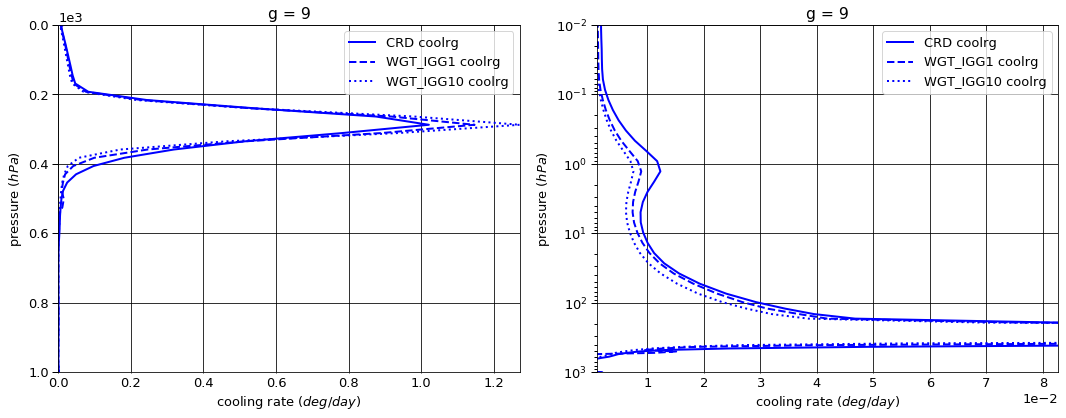

# Figure: cooling rate g-group 10

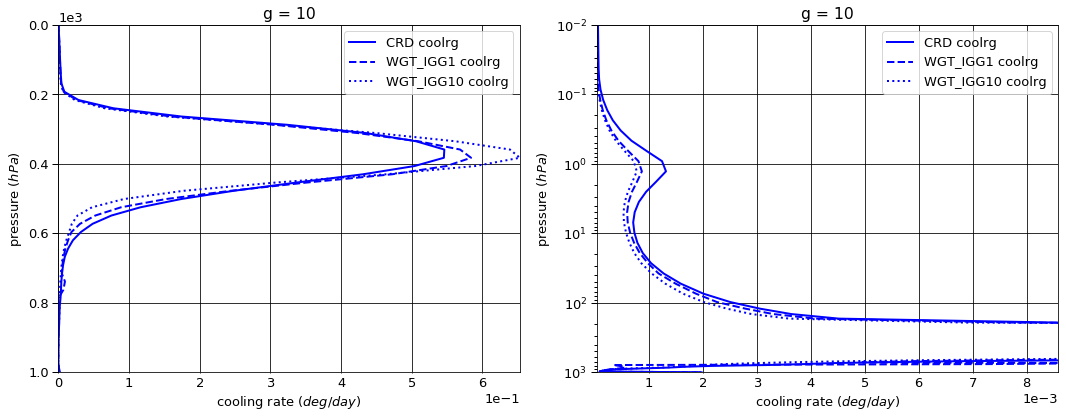

# Figure: cooling rate g-group total

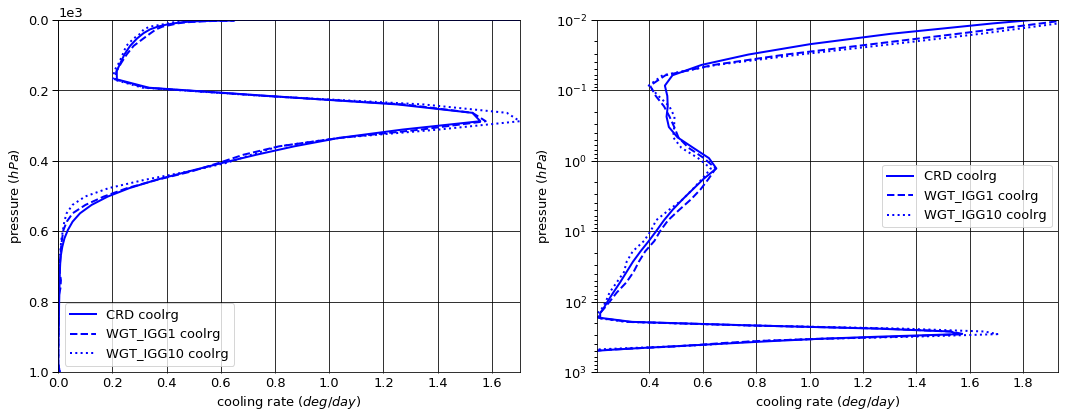

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007271   0.000000  -0.007271
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.018946   0.000000  -0.018946
   1013.0   76     -0.027325   0.027318  -0.000007
3  0.0      1      -0.051676   0.000000  -0.051676
   1013.0   76     -0.062573   0.062557  -0.000016
4  0.0      1      -0.117935   0.000000  -0.117935
   1013.0   76     -0.147918   0.147881  -0.000037
5  0.0      1      -0.366457   0.000000  -0.366457
   1013.0   76     -0.517723   0.517593  -0.000130
6  0.0      1      -0.735939   0.000000  -0.735939
   1013.0   76     -1.153129   1.152845  -0.000284
7  0.0      1      -2.549891   0.000000  -2.549891
   1013.0   76     -4.245155   4.244088  -0.001067
8  0.0      1      -7.529076   0.000000  -7.529076
   1013.0   76    -12.043012  12.039975  -0.003036
9  0.0      1     -14.069807   0.000000 -14.069807
   1013.0   76    -21.134527  21.128988  -0.005539
10 0.0      1     -13.261362   0.000000 -13.261362
   1013.0   76    -18.787911  18.782442  -0.005469


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007179   0.000000  -0.007179
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.018986   0.000000  -0.018986
   1013.0   76     -0.027325   0.027318  -0.000007
3  0.0      1      -0.052165   0.000000  -0.052165
   1013.0   76     -0.062573   0.062557  -0.000016
4  0.0      1      -0.119010   0.000000  -0.119010
   1013.0   76     -0.147918   0.147881  -0.000037
5  0.0      1      -0.368836   0.000000  -0.368836
   1013.0   76     -0.517723   0.517593  -0.000130
6  0.0      1      -0.739612   0.000000  -0.739612
   1013.0   76     -1.153129   1.152845  -0.000284
7  0.0      1      -2.540444   0.000000  -2.540444
   1013.0   76     -4.245155   4.244088  -0.001067
8  0.0      1      -7.478462   0.000000  -7.478462
   1013.0   76    -12.043012  12.039975  -0.003036
9  0.0      1     -13.986058   0.000000 -13.986058
   1013.0   76    -21.134527  21.128988  -0.005539
10 0.0      1     -13.232950   0.000000 -13.232950
   1013.0   76    -18.787911  18.782454  -0.005457


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007171   0.000000  -0.007171
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.018755   0.000000  -0.018755
   1013.0   76     -0.027325   0.027318  -0.000007
3  0.0      1      -0.052468   0.000000  -0.052468
   1013.0   76     -0.062573   0.062557  -0.000016
4  0.0      1      -0.119746   0.000000  -0.119746
   1013.0   76     -0.147918   0.147881  -0.000037
5  0.0      1      -0.369384   0.000000  -0.369384
   1013.0   76     -0.517723   0.517593  -0.000130
6  0.0      1      -0.737622   0.000000  -0.737622
   1013.0   76     -1.153129   1.152845  -0.000284
7  0.0      1      -2.527373   0.000000  -2.527373
   1013.0   76     -4.245155   4.244088  -0.001067
8  0.0      1      -7.514359   0.000000  -7.514359
   1013.0   76    -12.043012  12.039975  -0.003036
9  0.0      1     -13.958814   0.000000 -13.958814
   1013.0   76    -21.134527  21.128988  -0.005539
10 0.0      1     -13.150645   0.000000 -13.150645
   1013.0   76    -18.787911  18.782454  -0.005457


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      9.227160e-05  0.000000e+00  9.227160e-05
   1013.0   76     0.000000e+00  0.000000e+00 -4.235165e-22
2  0.0      1     -4.038700e-05  0.000000e+00 -4.038700e-05
   1013.0   76     0.000000e+00  3.469447e-18 -8.470329e-22
3  0.0      1     -4.889390e-04  0.000000e+00 -4.889390e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.075120e-03  0.000000e+00 -1.075120e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -2.378960e-03  0.000000e+00 -2.378960e-03
   1013.0   76     0.000000e+00 -1.110223e-16  2.710505e-20
6  0.0      1     -3.672740e-03  0.000000e+00 -3.672740e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      9.447200e-03  0.000000e+00  9.447200e-03
   1013.0   76     8.881784e-16 -8.881784e-16  0.000000e+00
8  0.0      1      5.061360e-02  0.000000e+00  5.061360e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      8.374900e-02  0.000000e+00  8.374900e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      2.841200e-02  0.000000e+00  2.841200e-02
   1013.0   76    -3.552714e-15  1.200000e-05  1.159770e-05


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.004162e-04  0.000000e+00  1.004162e-04
   1013.0   76     0.000000e+00  0.000000e+00 -4.235165e-22
2  0.0      1      1.905120e-04  0.000000e+00  1.905120e-04
   1013.0   76     0.000000e+00  3.469447e-18 -8.470329e-22
3  0.0      1     -7.921430e-04  0.000000e+00 -7.921430e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.811080e-03  0.000000e+00 -1.811080e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -2.927270e-03  0.000000e+00 -2.927270e-03
   1013.0   76     0.000000e+00 -1.110223e-16  2.710505e-20
6  0.0      1     -1.682910e-03  0.000000e+00 -1.682910e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.251790e-02  0.000000e+00  2.251790e-02
   1013.0   76     8.881784e-16 -8.881784e-16  0.000000e+00
8  0.0      1      1.471630e-02  0.000000e+00  1.471630e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      1.109930e-01  0.000000e+00  1.109930e-01
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      1.107170e-01  0.000000e+00  1.107170e-01
   1013.0   76    -3.552714e-15  1.200000e-05  1.159770e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      4.811285
   1001.112500 75     0.000001
2  0.000312    1      0.411628
   1001.112500 75     0.000003
3  0.000312    1      0.053767
   1001.112500 75     0.000006
4  0.000312    1      0.000045
   1001.112500 75     0.000013
5  0.000312    1      0.000930
   1001.112500 75     0.000047
6  0.000312    1      0.000513
   1001.112500 75     0.000103
7  0.000312    1      0.000514
   1001.112500 75     0.000386
8  0.000312    1      0.004065
   1001.112500 75     0.001098
9  0.000312    1      0.001544
   1001.112500 75     0.002003
10 0.000312    1      0.000043
   1001.112500 75     0.001977


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.966788
   1001.112500 75     0.000001
2  0.000312    1      0.263337
   1001.112500 75     0.000003
3  0.000312    1      0.024896
   1001.112500 75     0.000006
4  0.000312    1      0.000069
   1001.112500 75     0.000013
5  0.000312    1      0.000840
   1001.112500 75     0.000047
6  0.000312    1      0.000568
   1001.112500 75     0.000103
7  0.000312    1      0.000456
   1001.112500 75     0.000386
8  0.000312    1      0.003530
   1001.112500 75     0.001098
9  0.000312    1      0.001061
   1001.112500 75     0.002003
10 0.000312    1      0.000028
   1001.112500 75     0.001973


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      2.438445
   1001.112500 75     0.000001
2  0.000312    1      0.226422
   1001.112500 75     0.000003
3  0.000312    1      0.020714
   1001.112500 75     0.000006
4  0.000312    1      0.000064
   1001.112500 75     0.000013
5  0.000312    1      0.000760
   1001.112500 75     0.000047
6  0.000312    1      0.000476
   1001.112500 75     0.000103
7  0.000312    1      0.000330
   1001.112500 75     0.000386
8  0.000312    1      0.002438
   1001.112500 75     0.001098
9  0.000312    1      0.000879
   1001.112500 75     0.002003
10 0.000312    1      0.000024
   1001.112500 75     0.001973


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.844497e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.482907e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.887046e-02
   1001.112500 75     8.470329e-22
4  0.000312    1      2.411785e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -9.020683e-05
   1001.112500 75     0.000000e+00
6  0.000312    1      5.435330e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -5.738000e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -5.348270e-04
   1001.112500 75     0.000000e+00
9  0.000312    1     -4.836010e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.538504e-05
   1001.112500 75    -4.747200e-06


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.372841e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.852064e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -3.305222e-02
   1001.112500 75     8.470329e-22
4  0.000312    1      1.895370e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -1.698104e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -3.766357e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.840579e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.626829e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -6.655526e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.926468e-05
   1001.112500 75    -4.747200e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.708360,0.000000,-38.708360
1013.0,76,-58.131733,58.116144,-0.015588



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.543702,0.000000,-38.543702
1013.0,76,-58.131733,58.116156,-0.015576



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.456338,0.000000,-38.456338
1013.0,76,-58.131733,58.116156,-0.015576



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.646579e-01,0.000000,0.164658
1013.0,76,-7.105427e-15,0.000012,0.000012



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.520217e-01,0.000000,0.252022
1013.0,76,-7.105427e-15,0.000012,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.284334
1001.112500,75,0.005637



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.261573
1001.112500,75,0.005632



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.690550
1001.112500,75,0.005632



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.022761
1001.112500,75,-0.000005



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.593784
1001.112500,75,-0.000005


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000250,0.000219
2,0.000485,0.000474
3,0.001324,0.001098
4,0.003015,0.002605
5,0.011074,0.009089
6,0.024324,0.020338
7,0.090544,0.074488
8,0.248324,0.211068
9,0.383882,0.366104


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000250,0.000219,0.000250,0.000219,1.0
2,1.309690e-17,0.119479,0.000485,0.000474,0.000735,0.000692,1.0
3,1.564810e-18,0.119479,0.001324,0.001098,0.002059,0.001791,1.0
4,4.601703e-18,2.940742,0.003015,0.002605,0.005074,0.004395,30.0
5,5.682550e-19,0.123488,0.011074,0.009089,0.016147,0.013484,30.0
6,6.154553e-19,1.083062,0.024324,0.020338,0.040471,0.033822,300.0
7,7.853808e-20,0.127610,0.090544,0.074488,0.131015,0.108310,300.0
8,1.002222e-20,0.127610,0.248324,0.211068,0.379338,0.319378,300.0
9,1.278933e-21,0.127610,0.383882,0.366104,0.763221,0.685482,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.496473e-16  1.439570e-16   2.428832  1.751459e-02
      2  0.000312     1.492812e-17  8.572703e-18   1.741355  8.924316e-04
      3  0.000312     1.100844e-18  4.009486e-19   2.745598  5.202641e-05
      4  0.000312     6.994370e-22  6.978392e-22   1.002290  5.946961e-08
      5  0.000312     2.678629e-21  1.621111e-21   1.652341  1.650735e-07
      6  0.000312     5.761150e-22  4.302920e-22   1.338893  4.036970e-08
      7  0.000312     1.262869e-22  4.973905e-23   2.538989  8.147176e-09
      8  0.000312     4.196711e-22  3.549740e-23  11.822588  2.265300e-08
      9  0.000312     8.448528e-23  3.997504e-24  21.134508  4.453091e-09
      10 0.000312     3.362939e-24  3.497096e-25   9.616376  1.837477e-10
2     1  0.000750     3.501650e-16  1.442141e-16   2.428092  7.066144e-03
      2  0.000750     1.499866e-17  8.610481e-18   1.741907  3.610925e-04
      3  0.000750     1.105049e-18  4.040103e-19   2.735201  2.107233e-05
      4  0.000750     9.385713e-22  9.369246e-22   1.001758  3.215512e-08
      5  0.000750     2.719407e-21  1.658660e-21   1.639521  6.781064e-08
      6  0.000750     5.809322e-22  4.344427e-22   1.337189  1.640961e-08
      7  0.000750     1.273936e-22  5.040873e-23   2.527214  3.313540e-09
      8  0.000750     4.211227e-22  3.568394e-23  11.801464  9.156763e-09
      9  0.000750     8.475387e-23  4.020132e-24  21.082361  1.799484e-09
      10 0.000750     3.392875e-24  3.517994e-25   9.644344  7.465591e-11
3     1  0.001052     3.512557e-16  1.446637e-16   2.428085  9.940338e-03
      2  0.001052     1.514100e-17  8.675942e-18   1.745170  5.106494e-04
      3  0.001052     1.112182e-18  4.080862e-19   2.725362  2.979173e-05
      4  0.001052     1.114414e-21  1.112664e-21   1.001572  5.354920e-08
      5  0.001052     2.764613e-21  1.697193e-21   1.628933  9.704655e-08
      6  0.001052     5.868149e-22  4.388527e-22   1.337157  2.324600e-08
      7  0.001052     1.290489e-22  5.110477e-23   2.525184  4.708030e-09
      8  0.001052     4.240622e-22  3.593231e-23  11.801694  1.293093e-08
      9  0.001052     8.532077e-23  4.052462e-24  21.054058  2.540555e-09
      10 0.001052     3.455989e-24  3.550868e-25   9.732800  1.065813e-10
4     1  0.001476     3.524068e-16  1.451549e-16   2.427798  1.399173e-02
      2  0.001476     1.529394e-17  8.747656e-18   1.748347  7.228701e-04
      3  0.001476     1.120115e-18  4.128186e-19   2.713335  4.217873e-05
      4  0.001476     1.356328e-21  1.354457e-21   1.001382  9.144364e-08
      5  0.001476     2.820008e-21  1.745300e-21   1.615773  1.395399e-07
      6  0.001476     5.937816e-22  4.442528e-22   1.336585  3.300777e-08
      7  0.001476     1.309433e-22  5.196679e-23   2.519750  6.704834e-09
      8  0.001476     4.272435e-22  3.622017e-23  11.795735  1.827729e-08
      9  0.001476     8.592900e-23  4.089347e-24  21.012887  3.589747e-09
      10 0.001476     3.524273e-24  3.588011e-25   9.822359  1.523872e-10
5     1  0.002070     3.535557e-16  1.456718e-16   2.427070  1.969149e-02
      2  0.002070     1.545016e-17  8.823406e-18   1.751042  1.023343e-03
      3  0.002070     1.128633e-18  4.182299e-19   2.698594  5.975974e-05
      4  0.002070     1.689537e-21  1.687522e-21   1.001194  1.597876e-07
      5  0.002070     2.887494e-21  1.805221e-21   1.599523  2.016034e-07
      6  0.002070     6.019561e-22  4.508561e-22   1.335140  4.696590e-08
      7  0.002070     1.330586e-22  5.303301e-23   2.508977  9.564613e-09
      8  0.002070     4.305175e-22  3.654877e-23  11.779260  2.583386e-08
      9  0.002070     8.654699e-23  4.130579e-24  20.952751  5.071591e-09
      10 0.002070     3.594287e-24  3.628823e-25   9.904829  2.178670e-10
6     1  0.002904     3.547013e-16  1.462239e-16   2.425740  2.771894e-02
      2  0.002904     1.561036e-17  8.904750e-18   1.753037  1.449423e-03
      3  0.002904     1.137928e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
